In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [ ]:
class OrderBookAnalyzer:
    def __init__(self, base_path='.'):
        self.base_path = Path(base_path)
        self.tickers = ['CRWV', 'FROG', 'SOUN']
        
    def load_monthly_data(self, ticker):
        """Load all CSV files for a ticker (one month of data)"""
        ticker_path = self.base_path / ticker
        csv_files = list(ticker_path.glob(f"{ticker}_*.csv"))
        
        if not csv_files:
            print(f"No files found for {ticker}")
            return None
            
        print(f"Loading {len(csv_files)} files for {ticker}")
        
        dfs = []
        for file in csv_files:
            try:
                df = pd.read_csv(file)
                
                # Handle duplicate ts_event columns
                if list(df.columns).count('ts_event') > 1:
                    cols = list(df.columns)
                    first_ts_event = cols.index('ts_event')
                    df = df.iloc[:, [i for i, col in enumerate(cols) if col != 'ts_event' or i == first_ts_event]]
                
                # Fix: Use flexible datetime parsing for mixed formats
                df['ts_event'] = pd.to_datetime(df['ts_event'], format='mixed', utc=True)
                df['date'] = df['ts_event'].dt.date
                dfs.append(df)
                
            except Exception as e:
                print(f"Error loading {file.name}: {e}")
                continue
        
        if dfs:
            combined_df = pd.concat(dfs, ignore_index=True)
            combined_df = combined_df.sort_values('ts_event').reset_index(drop=True)
            print(f"Loaded {len(combined_df):,} total records")
            return combined_df
        return None
    
    def load_single_day(self, ticker, date_pattern):
        """Load single day data for slippage analysis"""
        ticker_path = self.base_path / ticker
        csv_files = list(ticker_path.glob(f"{ticker}_{date_pattern}*.csv"))
        
        if not csv_files:
            print(f"No files found for {ticker} on {date_pattern}")
            return None
            
        file = csv_files[0]
        print(f"Loading: {file.name}")
        
        try:
            df = pd.read_csv(file)
            
            # Handle duplicate ts_event columns
            if list(df.columns).count('ts_event') > 1:
                cols = list(df.columns)
                first_ts_event = cols.index('ts_event')
                df = df.iloc[:, [i for i, col in enumerate(cols) if col != 'ts_event' or i == first_ts_event]]
            
            # Fix: Use flexible datetime parsing for mixed formats
            df['ts_event'] = pd.to_datetime(df['ts_event'], format='mixed', utc=True)
            print(f"Loaded {len(df):,} records")
            return df
            
        except Exception as e:
            print(f"Error loading {file.name}: {e}")
            return None
    
    def calculate_order_book_metrics(self, df):
        """Calculate core order book metrics"""
        # Basic price metrics
        df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2 # for every microsecond event
        df['spread'] = df['ask_px_00'] - df['bid_px_00']
        df['spread_bps'] = np.where(df['mid_price'] > 0, 
                                   (df['spread'] / df['mid_price']) * 10000, 
                                   np.nan)
        
        # Depth metrics
        bid_cols = [f'bid_sz_{i:02d}' for i in range(10) if f'bid_sz_{i:02d}' in df.columns]
        ask_cols = [f'ask_sz_{i:02d}' for i in range(10) if f'ask_sz_{i:02d}' in df.columns]
        
        df['total_bid_depth'] = df[bid_cols].sum(axis=1)
        df['total_ask_depth'] = df[ask_cols].sum(axis=1)
        df['total_depth'] = df['total_bid_depth'] + df['total_ask_depth']
        
        # Order book imbalance
        df['imbalance'] = np.where(df['total_depth'] > 0,
                                  (df['total_bid_depth'] - df['total_ask_depth']) / df['total_depth'],
                                  0)
        
        # Time features
        df['hour'] = df['ts_event'].dt.hour
        df['minute'] = df['ts_event'].dt.minute
        
        return df
    
    def calculate_buy_slippage_function(self, df, target_time=None, time_range=None, max_shares=None):
        """
        Calculate buy-side slippage for specified time
        
        Parameters:
        - target_time: specific time like "10:30" or "14:15"
        - time_range: time range like "10:00-11:00" for averaging
        - max_shares: maximum trade size to analyze
        """
        
        if target_time:
            # Find closest timestamp to target time
            target_hour, target_minute = map(int, target_time.split(':'))
            df['time_diff'] = abs((df['ts_event'].dt.hour * 60 + df['ts_event'].dt.minute) - 
                                 (target_hour * 60 + target_minute))
            snapshot_idx = df['time_diff'].idxmin()
            snapshot = df.iloc[snapshot_idx]
            
        elif time_range:
            # Average across time range
            start_time, end_time = time_range.split('-')
            start_hour, start_minute = map(int, start_time.split(':'))
            end_hour, end_minute = map(int, end_time.split(':'))
            
            start_minutes = start_hour * 60 + start_minute
            end_minutes = end_hour * 60 + end_minute
            
            df['total_minutes'] = df['ts_event'].dt.hour * 60 + df['ts_event'].dt.minute
            mask = (df['total_minutes'] >= start_minutes) & (df['total_minutes'] <= end_minutes)
            
            if not mask.any():
                print(f"No data found in time range {time_range}")
                return None
                
            # Average the order book levels
            time_subset = df[mask]
            snapshot = time_subset.mean()
            
        else:
            # Use first row as default
            snapshot = df.iloc[0]
        
        # Get ask-side order book levels
        ask_price_cols = [f'ask_px_{i:02d}' for i in range(10) if f'ask_px_{i:02d}' in df.columns]
        ask_size_cols = [f'ask_sz_{i:02d}' for i in range(10) if f'ask_sz_{i:02d}' in df.columns]
        
        mid_price = snapshot['mid_price']
        
        # Build order book levels
        levels = []
        for i in range(len(ask_price_cols)):
            price = snapshot[ask_price_cols[i]]
            size = snapshot[ask_size_cols[i]]
            
            if pd.notna(price) and pd.notna(size) and size > 0:
                levels.append({
                    'level': i,
                    'price': price,
                    'size': int(size)
                })
        
        total_liquidity = sum(level['size'] for level in levels)
        if max_shares is None:
            max_shares = min(total_liquidity, 10000)
        
        # Calculate slippage for each trade size
        trade_sizes = []
        slippages_dollars = []
        avg_prices = []
        
        for trade_size in range(1, max_shares + 1):
            shares_remaining = trade_size
            total_cost = 0
            shares_filled = 0
            
            # Walk through order book levels
            for level in levels:
                if shares_remaining <= 0:
                    break
                    
                shares_from_level = min(shares_remaining, level['size'])
                total_cost += shares_from_level * level['price']
                shares_filled += shares_from_level
                shares_remaining -= shares_from_level
            
            # If we couldn't fill the entire order
            if shares_remaining > 0:
                break
                
            # Calculate metrics
            avg_execution_price = total_cost / shares_filled
            slippage_dollars = avg_execution_price - mid_price
            
            trade_sizes.append(trade_size)
            slippages_dollars.append(slippage_dollars)
            avg_prices.append(avg_execution_price)
        
        return {
            'trade_sizes': np.array(trade_sizes),
            'slippage_dollars': np.array(slippages_dollars),
            'avg_execution_prices': np.array(avg_prices),
            'mid_price': mid_price,
            'max_fillable_size': len(trade_sizes),
            'analysis_time': target_time or time_range or 'first_timestamp'
        }
    
    def analyze_liquidity_patterns(self, df):
        """Analyze liquidity patterns over time (monthly data)"""
        
        # Ensure date column exists
        if 'date' not in df.columns:
            df['date'] = df['ts_event'].dt.date
        
        # Daily patterns
        daily_stats = df.groupby('date').agg({
            'spread_bps': ['mean', 'std'],
            'total_depth': ['mean', 'std'],
            'mid_price': ['first', 'last', 'min', 'max']
        })
        
        # Hourly patterns (across all days)
        hourly_stats = df.groupby('hour').agg({
            'spread_bps': ['mean', 'std'],
            'total_depth': ['mean', 'std'],
            'imbalance': 'mean'
        })
        
        return daily_stats, hourly_stats
    
    def create_order_book_visualizations(self, df):
        """Create order book analysis visualizations (monthly data)"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Ensure date column exists
        if 'date' not in df.columns:
            df['date'] = df['ts_event'].dt.date
        
        # Daily evolution (sample for performance)
        daily_sample = df.groupby('date').agg({
            'mid_price': 'mean', # average all microsecond mid_price everyday
            'spread_bps': 'mean', 
            'total_depth': 'mean'
        }).reset_index()
        
        # Price evolution
        axes[0,0].plot(daily_sample['date'], daily_sample['mid_price'], 'b-', linewidth=2)
        axes[0,0].set_title('Daily Mid Price Evolution')
        axes[0,0].set_ylabel('Price ($)')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Spread evolution
        axes[0,1].plot(daily_sample['date'], daily_sample['spread_bps'], 'r-', linewidth=2)
        axes[0,1].set_title('Daily Spread Evolution')
        axes[0,1].set_ylabel('Spread (bps)')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Depth evolution
        axes[1,0].plot(daily_sample['date'], daily_sample['total_depth'], 'g-', linewidth=2)
        axes[1,0].set_title('Daily Depth Evolution')
        axes[1,0].set_ylabel('Total Shares')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Order book levels visualization
        bid_levels = [f'bid_sz_{i:02d}' for i in range(10) if f'bid_sz_{i:02d}' in df.columns]
        ask_levels = [f'ask_sz_{i:02d}' for i in range(10) if f'ask_sz_{i:02d}' in df.columns]
        
        avg_bid_sizes = [df[col].mean() for col in bid_levels]
        avg_ask_sizes = [df[col].mean() for col in ask_levels]
        
        levels = list(range(len(avg_bid_sizes)))
        axes[1,1].bar([l - 0.2 for l in levels], avg_bid_sizes, width=0.4, label='Bid', alpha=0.7)
        axes[1,1].bar([l + 0.2 for l in levels], avg_ask_sizes, width=0.4, label='Ask', alpha=0.7)
        axes[1,1].set_title('Average Size by Order Book Level')
        axes[1,1].set_xlabel('Order Book Level')
        axes[1,1].set_ylabel('Average Size (shares)')
        axes[1,1].legend()
        
        plt.tight_layout()
        return fig
    
    def create_slippage_visualizations(self, slippage_result):
        """Create slippage analysis visualizations"""
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        trade_sizes = slippage_result['trade_sizes']
        analysis_time = slippage_result['analysis_time']
        
        # Buy-side slippage in dollars
        axes[0].plot(trade_sizes, slippage_result['slippage_dollars'], 'r-', linewidth=2)
        axes[0].set_title(f'Buy-Side Slippage Function ($) - {analysis_time}')
        axes[0].set_xlabel('Trade Size (shares)')
        axes[0].set_ylabel('Slippage ($)')
        axes[0].grid(True, alpha=0.3)
        
        # Marginal slippage
        marginal_slippage = np.diff(slippage_result['slippage_dollars'])
        axes[1].plot(trade_sizes[1:], marginal_slippage, 'purple', linewidth=2)
        axes[1].set_title(f'Marginal Slippage - {analysis_time}')
        axes[1].set_xlabel('Trade Size (shares)')
        axes[1].set_ylabel('Additional Slippage per Share ($)')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def print_summary_stats(self, df, slippage_result=None):
        """Print summary statistics"""
        
        # Ensure date column exists
        if 'date' not in df.columns:
            df['date'] = df['ts_event'].dt.date
        
        print(f"\n=== ORDER BOOK SUMMARY ===")
        print(f"Total records: {len(df):,}")
        print(f"Date range: {df['ts_event'].min().date()} to {df['ts_event'].max().date()}")
        print(f"Trading days: {df['date'].nunique()}")
        print(f"\nPrice metrics:")
        print(f"  Mid price range: ${df['mid_price'].min():.2f} - ${df['mid_price'].max():.2f}")
        print(f"  Average spread: {df['spread_bps'].mean():.2f} bps")
        print(f"  Average total depth: {df['total_depth'].mean():.0f} shares")
        
        if slippage_result:
            print(f"\n=== SLIPPAGE SUMMARY ({slippage_result['analysis_time']}) ===")
            print(f"Mid price: ${slippage_result['mid_price']:.4f}")
            print(f"Maximum fillable size: {slippage_result['max_fillable_size']:,} shares")
            
            # Common trade sizes
            common_sizes = [100, 500, 1000, 2000, 5000]
            trade_sizes = slippage_result['trade_sizes']
            slippage_dollars = slippage_result['slippage_dollars']
            
            print(f"\nSlippage at common trade sizes:")
            for size in common_sizes:
                if size <= len(trade_sizes):
                    idx = size - 1
                    print(f"  {size:,} shares: ${slippage_dollars[idx]:.4f}")
    
    def run_monthly_analysis(self, ticker):
        """Run complete monthly order book analysis"""
        
        print(f"\n{'='*50}")
        print(f"MONTHLY ANALYSIS: {ticker}")
        print(f"{'='*50}")
        
        # Load monthly data
        df = self.load_monthly_data(ticker)
        if df is None:
            return None
        
        # Calculate metrics
        df = self.calculate_order_book_metrics(df)
        
        # Analyze patterns
        daily_stats, hourly_stats = self.analyze_liquidity_patterns(df)
        
        # Create visualizations
        orderbook_fig = self.create_order_book_visualizations(df)
        
        # Print summary
        self.print_summary_stats(df)
        
        return {
            'data': df,
            'daily_stats': daily_stats,
            'hourly_stats': hourly_stats,
            'orderbook_fig': orderbook_fig
        }
    
    def run_slippage_analysis(self, ticker, date_pattern, target_time=None, time_range=None):
        """Run slippage analysis for specific time"""
        
        print(f"\n{'='*50}")
        print(f"SLIPPAGE ANALYSIS: {ticker} - {date_pattern}")
        print(f"{'='*50}")
        
        # Load single day data
        df = self.load_single_day(ticker, date_pattern)
        if df is None:
            return None
        
        # Calculate metrics
        df = self.calculate_order_book_metrics(df)
        
        # Calculate slippage function
        slippage_result = self.calculate_buy_slippage_function(df, target_time, time_range)
        if slippage_result is None:
            return None
        
        # Create visualizations
        slippage_fig = self.create_slippage_visualizations(slippage_result)
        
        # Print summary
        self.print_summary_stats(df, slippage_result)
        
        return {
            'data': df,
            'slippage_result': slippage_result,
            'slippage_fig': slippage_fig
        }


MONTHLY ANALYSIS: CRWV
Loading 21 files for CRWV
Loaded 1,882,484 total records

=== ORDER BOOK SUMMARY ===
Total records: 1,882,484
Date range: 2025-04-03 to 2025-05-02
Trading days: 21

Price metrics:
  Mid price range: $33.52 - $57.62
  Average spread: 21.75 bps
  Average total depth: 6304 shares

SLIPPAGE ANALYSIS: CRWV - 2025-04-04
Loading: CRWV_2025-04-04 00:00:00+00:00.csv
Loaded 118,486 records

=== ORDER BOOK SUMMARY ===
Total records: 118,486
Date range: 2025-04-04 to 2025-04-04
Trading days: 1

Price metrics:
  Mid price range: $43.56 - $50.95
  Average spread: 26.30 bps
  Average total depth: 5458 shares

=== SLIPPAGE SUMMARY (10:30) ===
Mid price: $49.6000
Maximum fillable size: 3,299 shares

Slippage at common trade sizes:
  100 shares: $0.1000
  500 shares: $0.4565
  1,000 shares: $0.8016
  2,000 shares: $1.0472


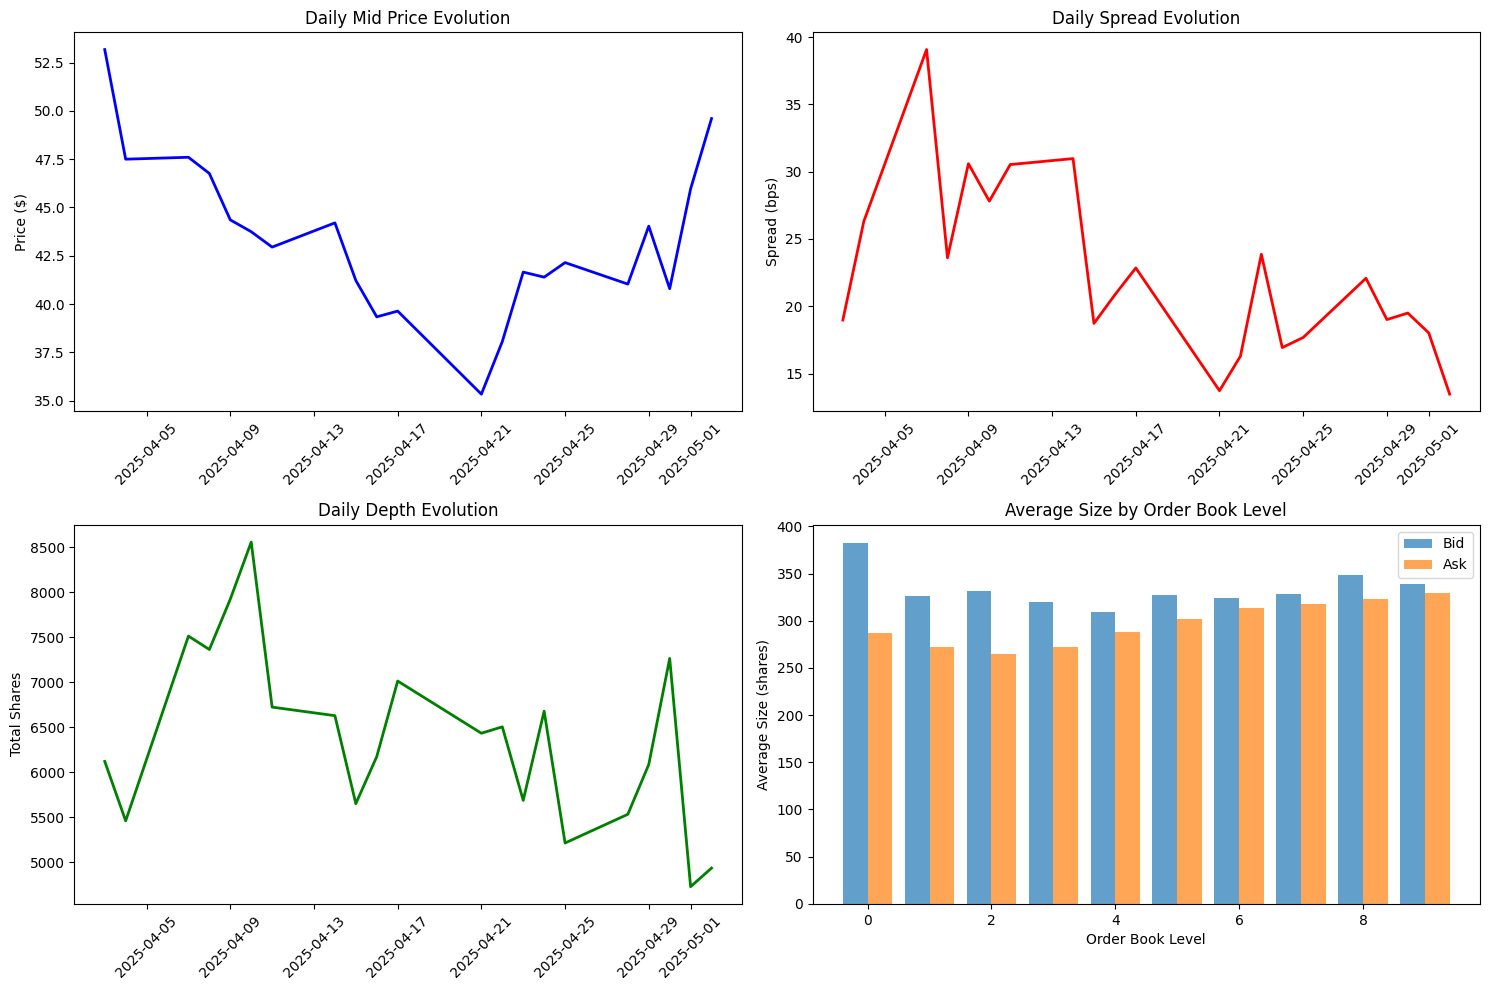

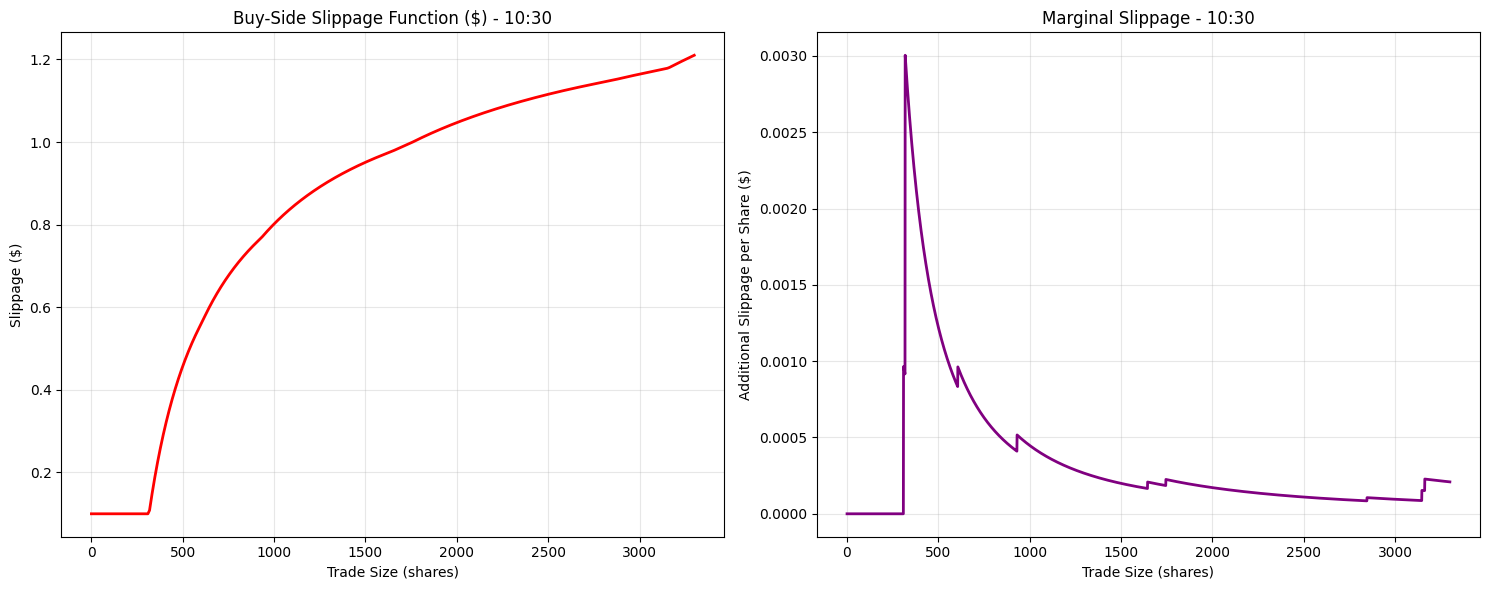

In [7]:
# Usage Examples:
analyzer = OrderBookAnalyzer()

# Monthly analysis
monthly_results = analyzer.run_monthly_analysis('CRWV')

# Slippage analysis - specific time
slippage_results = analyzer.run_slippage_analysis('CRWV', '2025-04-04', target_time='10:30')